In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, anderson


In [2]:
df_session = pd.read_csv(r"C:\Users\Evgeniya\финальная работа\ga_sessions.csv", low_memory=False)

In [3]:
df_hits = pd.read_csv(r"C:\Users\Evgeniya\финальная работа\ga_hits.csv")

# 1. РАЗВЕДОЧНЫЙ АНАЛИЗ(EDA) 

## DF_HITS

In [6]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [7]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [8]:
df_hits['hit_date'] = pd.to_datetime(df_hits['hit_date'])
df_hits['hit_time'] = pd.to_numeric(df_hits['hit_time'], errors='coerce').fillna(0).astype('Int64')

In [9]:
df_hits.isnull().sum() # столбцы с пустыми значениями

session_id               0
hit_date                 0
hit_time                 0
hit_number               0
hit_type                 0
hit_referer        6274804
hit_page_path            0
event_category           0
event_action             0
event_label        3760184
event_value       15726470
dtype: int64

In [10]:
print((df_hits.isnull().sum() / len(df_hits)) * 100) # посмотрим процент пропущенных значений

session_id          0.000000
hit_date            0.000000
hit_time            0.000000
hit_number          0.000000
hit_type            0.000000
hit_referer        39.899634
hit_page_path       0.000000
event_category      0.000000
event_action        0.000000
event_label        23.909905
event_value       100.000000
dtype: float64


In [11]:
# колонка event_value 100% пропусков, колонка hit_referer - 40% пропусков, удалим их 
df_hits.drop(columns=['hit_referer', 'event_value'], inplace=True)

In [12]:
# проверим колонку event_label, т.к. тоже большое количество пропущенных значений
# Проверим уникальные значения и их количество
df_hits['event_label'].value_counts()

event_label
KclpemfoHstknWHFiLit    6505447
hAHqGICPFQiPwtzubOzs    1284914
OHfyUfDKdPgBdvelDlfG     626554
pzAKUYdRKNEUXxxBFUPX     358915
ghOrjqpgskpGHSFfBBsi     342500
                         ...   
iFTveknOEiHmdgIHHqBZ          1
WKfoFxrMANSjHQMIhCZr          1
RAJXTkPWctNbMZubUIng          1
jRptuMMybqHerOxplPYo          1
aNlmojNIfsJaXKZHCDiU          1
Name: count, Length: 39825, dtype: int64

In [13]:
# Количество уникальных значений в event_label
df_hits['event_label'].nunique()

39825

In [14]:
# event_label не нужен для расчётов CR и гипотез, количество уникальных и пропущенных значений велико, поэтому тоже удалим этот столбец
df_hits.drop(columns=['event_label'], inplace=True)

In [15]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   session_id      object        
 1   hit_date        datetime64[ns]
 2   hit_time        Int64         
 3   hit_number      int64         
 4   hit_type        object        
 5   hit_page_path   object        
 6   event_category  object        
 7   event_action    object        
dtypes: Int64(1), datetime64[ns](1), int64(1), object(5)
memory usage: 974.9+ MB


In [16]:
# проверим на общие дубликаты
print(df_hits.duplicated().sum())

4009


In [17]:
# проверим дубликаты по session_id. 
# Одинаковые session_id, но разные hit_number и hit_page_path
# Это нормально, потому что одна сессия может включать много событий (просмотр карточек, клики и т. д.)
# И как итог: удалять дубликаты не будем.

print(df_hits[df_hits.duplicated(subset=['session_id'])])

                                         session_id   hit_date  hit_time  \
23        3117547552978670057.1640217454.1640217454 2021-12-23      1032   
32        3282323002617677961.1640266499.1640266499 2021-12-23       677   
39         562366956183957396.1640246520.1640246520 2021-12-23       724   
42         628849304731384746.1640233987.1640233987 2021-12-23      1090   
61        2530706414478031710.1640233887.1640233887 2021-12-23      1690   
...                                             ...        ...       ...   
15726465  6866159858916559617.1640270865.1640270865 2021-12-23    810589   
15726466  7310304587364460692.1640261783.1640261783 2021-12-23    904927   
15726467  8013702685784312179.1640270195.1640270195 2021-12-23   2172865   
15726468  8021505554734405918.1640257821.1640257821 2021-12-23    713325   
15726469  1569014437485249865.1640269129.1640269129 2021-12-23    742820   

          hit_number hit_type  \
23                 5    event   
32                 7 

## DF_SESSION

In [19]:
df_session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [20]:
df_session.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [21]:
# visit_date и visit_time хранятся как object (нужно преобразовать в datetime)
df_session['visit_date'] = pd.to_datetime(df_session['visit_date'])
df_session['visit_time'] = pd.to_datetime(df_session['visit_time'], format='%H:%M:%S').dt.time


In [22]:
print(df_session['visit_time'].unique())

[datetime.time(14, 36, 32) datetime.time(8, 21, 30)
 datetime.time(2, 42, 6) ... datetime.time(4, 51) datetime.time(5, 38, 51)
 datetime.time(4, 30, 9)]


In [23]:
print((df_session.isnull().sum() / len(df_session)) * 100) # посмотрим процент пропущенных значений

session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.005215
utm_medium                   0.000000
utm_campaign                11.806346
utm_adcontent               18.043410
utm_keyword                 58.174009
device_category              0.000000
device_os                   57.533002
device_brand                19.740307
device_model                99.121633
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64


In [24]:
# огромный процент пропусков у device_model, device_os, utm_keyword. Удалим их, т.к. для анализа они нам не нужны
df_session.drop(columns=['device_model', 'utm_keyword', 'device_os'], inplace=True)

In [25]:
# Заполнение пропусков в важных столбцах значением "unknown"
df_session.fillna({
    'utm_campaign': 'unknown',
    'utm_adcontent': 'unknown',
    'utm_source': 'unknown',
    'device_brand': 'unknown'
}, inplace=True)

In [26]:
# Проверка изменений
print(df_session.info())  # Вывод структуры данных после обработки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 15 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 object        
 2   visit_date                datetime64[ns]
 3   visit_time                object        
 4   visit_number              int64         
 5   utm_source                object        
 6   utm_medium                object        
 7   utm_campaign              object        
 8   utm_adcontent             object        
 9   device_category           object        
 10  device_brand              object        
 11  device_screen_resolution  object        
 12  device_browser            object        
 13  geo_country               object        
 14  geo_city                  object        
dtypes: datetime64[ns](1), int64(1), object(13)
memory usage: 212.9+ MB
None


## ОБЪЕДИНЕНИЕ ТАБЛИЦ

In [28]:
# Объединение данных по session_id
df = df_hits.merge(df_session, on='session_id', how='left')


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 22 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   hit_date                  datetime64[ns]
 2   hit_time                  Int64         
 3   hit_number                int64         
 4   hit_type                  object        
 5   hit_page_path             object        
 6   event_category            object        
 7   event_action              object        
 8   client_id                 object        
 9   visit_date                datetime64[ns]
 10  visit_time                object        
 11  visit_number              float64       
 12  utm_source                object        
 13  utm_medium                object        
 14  utm_campaign              object        
 15  utm_adcontent             object        
 16  device_category           object        
 17  device

In [30]:
# Сохранение в CSV
df.to_csv(r"C:\Users\Evgeniya\финальная работа\merged.csv", index=False, encoding='utf-8')

In [31]:
# смотрим пропуски
print((df.isnull().sum() / len(df)) * 100)

session_id                  0.000000
hit_date                    0.000000
hit_time                    0.000000
hit_number                  0.000000
hit_type                    0.000000
hit_page_path               0.000000
event_category              0.000000
event_action                0.000000
client_id                   0.262303
visit_date                  0.262303
visit_time                  0.262303
visit_number                0.262303
utm_source                  0.262303
utm_medium                  0.262303
utm_campaign                0.262303
utm_adcontent               0.262303
device_category             0.262303
device_brand                0.262303
device_screen_resolution    0.262303
device_browser              0.262303
geo_country                 0.262303
geo_city                    0.262303
dtype: float64


In [32]:
df_missing_client_id = df[df['client_id'].isna()]
df['client_id'].isna().sum()

41251

In [33]:
df_missing_client_id[['utm_source', 'device_category', 'geo_city', 'visit_date', 'visit_time', 'utm_medium', 'device_brand', 'geo_country']].describe(include='all')


,utm_source,device_category,geo_city,visit_date,visit_time,utm_medium,device_brand,geo_country
count,0,0,0,0,0,0,0,0
unique,0,0,0,NaN,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [34]:
# видим, что все пустые строки по client_id тоже пустые, поэтому просто удалим эти строки (восстановить всю информацию будет проблематично)
df = df.dropna(subset=['client_id'])

In [35]:
# проверим пропуски после удаления
print((df.isnull().sum() / len(df)) * 100)

session_id                  0.0
hit_date                    0.0
hit_time                    0.0
hit_number                  0.0
hit_type                    0.0
hit_page_path               0.0
event_category              0.0
event_action                0.0
client_id                   0.0
visit_date                  0.0
visit_time                  0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
device_category             0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
dtype: float64


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15685219 entries, 0 to 15726469
Data columns (total 22 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   hit_date                  datetime64[ns]
 2   hit_time                  Int64         
 3   hit_number                int64         
 4   hit_type                  object        
 5   hit_page_path             object        
 6   event_category            object        
 7   event_action              object        
 8   client_id                 object        
 9   visit_date                datetime64[ns]
 10  visit_time                object        
 11  visit_number              float64       
 12  utm_source                object        
 13  utm_medium                object        
 14  utm_campaign              object        
 15  utm_adcontent             object        
 16  device_category           object        
 17  device_bran

In [37]:
df.head(10)

,session_id,hit_date,hit_time,hit_number,hit_type,hit_page_path,event_category,event_action,client_id,visit_date,...,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864,30,event,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,1313077071.1640254048,2021-12-23,...,kjsLglQLzykiRbcDiGcD,cpc,unknown,unknown,mobile,Huawei,360x780,Chrome,Russia,Saint Petersburg
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331,41,event,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,1804519513.1640268211,2021-12-23,...,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x851,Chrome,Russia,Chelyabinsk
2,885342191847998240.1640235807.1640235807,2021-12-23,796252,49,event,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,206134792.1640235808,2021-12-23,...,BHcvLfOaCWvWTykYqHVe,cpc,unknown,unknown,desktop,unknown,2560x1080,Chrome,Russia,Moscow
3,142526202120934167.1640211014.1640211014,2021-12-23,934292,46,event,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,33184467.1620742935,2021-12-23,...,BHcvLfOaCWvWTykYqHVe,cpc,unknown,unknown,mobile,Samsung,412x915,Chrome,Russia,Podolsk
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741,79,event,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,803285769.1640265077,2021-12-23,...,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,unknown,1536x864,Chrome,Estonia,Tallinn
5,6466333295973247896.1640246168.1640246168,2021-12-23,704194,41,event,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,1505560543.1640246168,2021-12-23,...,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,unknown,1920x1080,YaBrowser,Russia,Moscow
6,281215510786615563.1640245516.1640245516,2021-12-23,911854,102,event,sberauto.com/cars/toyota?isnew=false&rental_ca...,quiz,quiz_show,65475588.1640245515,2021-12-23,...,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Apple,375x812,Safari,Russia,Vladivostok
7,4024492994895054107.1640269084.1640269084,2021-12-23,1071804,85,event,sberauto.com/cars/all/mercedes-benz/glc/f8f330...,quiz,quiz_show,937025294.1640269083,2021-12-23,...,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,unknown,1536x864,Chrome,Russia,Ulyanovsk
8,555009234841130092.1640256620.1640256620,2021-12-23,1013899,101,event,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,129223157.1640256620,2021-12-23,...,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,desktop,unknown,1920x1080,Chrome,Russia,Saint Petersburg
9,2692901778487480807.1640206845.1640206845,2021-12-23,0,1,event,sberauto.com/cars/all/nissan/x-trail/0744675f?...,card_web,view_card,626990054.1640206823,2021-12-23,...,kjsLglQLzykiRbcDiGcD,cpc,unknown,unknown,mobile,Apple,414x896,Safari,Russia,Moscow


# 2. Анализ распределений ключевых атрибутов и их взаимосвязей

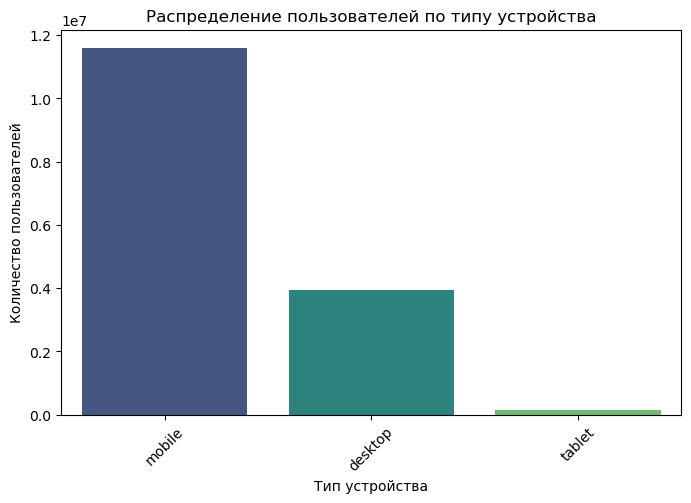

In [39]:
# 1. Распределение категорий устройств

plt.figure(figsize=(8, 5))
sns.countplot(x=df['device_category'], hue=df['device_category'], 
              order=df['device_category'].value_counts().index, 
              palette="viridis", legend=False)  
plt.title('Распределение пользователей по типу устройства')
plt.xlabel('Тип устройства')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.show()

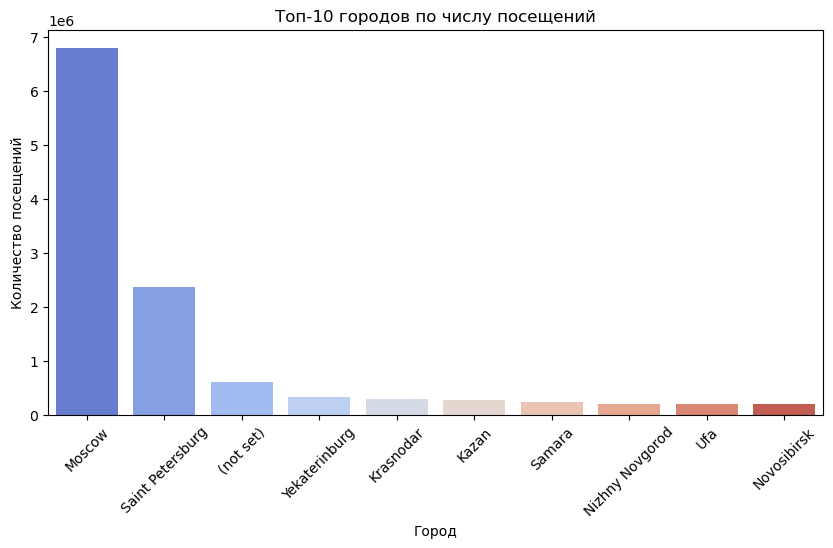

In [40]:
# 2. Распределение посещений по регионам (топ-10 городов)

top_cities = df['geo_city'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_cities.index, y=top_cities.values, hue=top_cities.index, palette="coolwarm", dodge=False)
plt.title('Топ-10 городов по числу посещений')
plt.xlabel('Город')
plt.ylabel('Количество посещений')
plt.xticks(rotation=45)
plt.show()

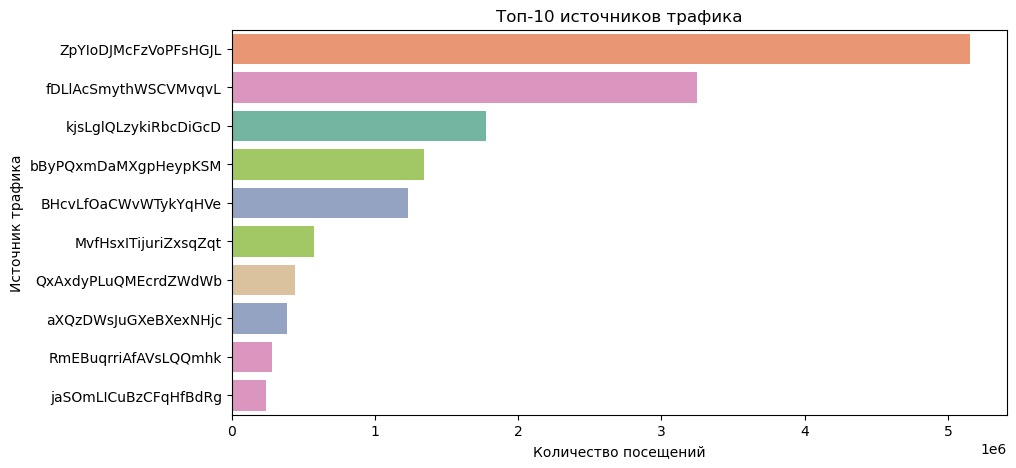

In [41]:
# 3. Распределение источников трафика (utm_source)

plt.figure(figsize=(10, 5))
sns.countplot(y=df['utm_source'], hue=df['utm_source'], 
              order=df['utm_source'].value_counts().index[:10], 
              palette="Set2", dodge=False)
plt.title('Топ-10 источников трафика')
plt.xlabel('Количество посещений')
plt.ylabel('Источник трафика')
plt.legend([],[], frameon=False)  
plt.show()

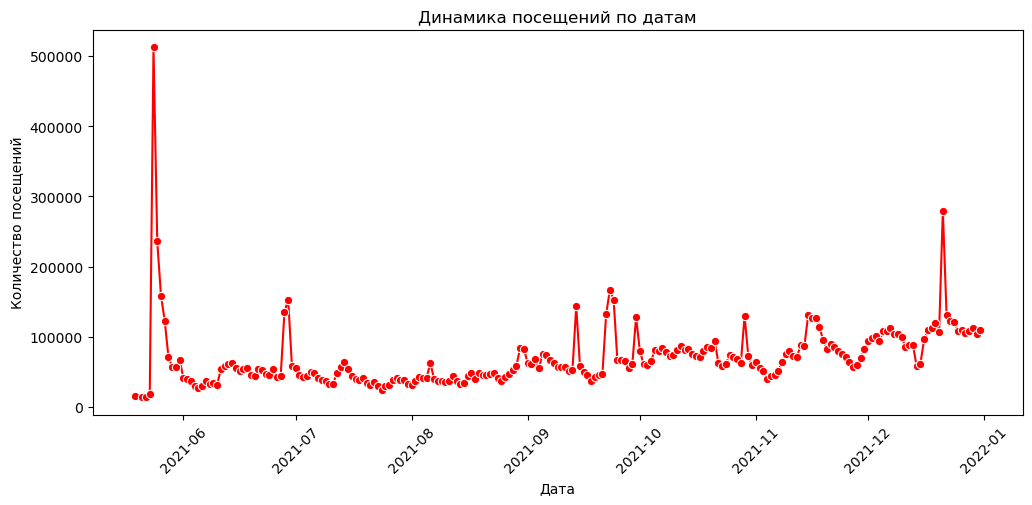

In [42]:
# 4. Гистограмма количества посещений по датам

plt.figure(figsize=(12, 5))
visit_counts = df['visit_date'].value_counts().sort_index()
sns.lineplot(x=visit_counts.index, y=visit_counts.values, marker="o", color="red")
plt.title('Динамика посещений по датам')
plt.xlabel('Дата')
plt.ylabel('Количество посещений')
plt.xticks(rotation=45)
plt.show()

In [43]:
# ВЫВОД:  1. Распределение по типу устройства: преобладает мобильный трафик.
#         2. Топ-10 городов по посещениям: лидируют Москва и Санкт-Петербург, что логично, учитывая концентрацию целевой аудитории.
#         3. Топ-10 источников трафика (utm_source): большая часть пользователей приходит из нескольких ключевых источников.
#         4. Динамика посещений по датам: визуально можно заметить периоды роста и спада активности.

# 3. Анализ конверсии и проверка гипотез

## Конверсия

In [46]:
# Определяем целевые события

target_events = [
    'sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click',
    'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click',
    'sub_submit_success', 'sub_car_request_submit_click']


In [47]:
# Создаем признак конверсии: если в сессии есть хотя бы одно целевое действие, то конверсия = 1
df['is_converted'] = df['event_action'].isin(target_events).astype(int)

In [48]:
# Группируем по session_id и определяем, была ли конверсия в рамках сессии
session_conversion = df.groupby('session_id')['is_converted'].max().reset_index()

In [49]:
# Определяем органический и платный трафик
organic_mediums = ['organic', 'referral', '(none)']
df['traffic_type'] = df['utm_medium'].apply(lambda x: 'organic' if x in organic_mediums else 'paid')

In [50]:
# Объединяем данные по session_id для дальнейшего анализа
df_sessions = df[['session_id', 'traffic_type', 'device_category', 'geo_city']].drop_duplicates()
df_sessions = df_sessions.merge(session_conversion, on='session_id', how='left')


In [51]:
df_sessions.head()

,session_id,traffic_type,device_category,geo_city,is_converted
0,5639623078712724064.1640254056.1640254056,paid,mobile,Saint Petersburg,0
1,7750352294969115059.1640271109.1640271109,paid,mobile,Chelyabinsk,0
2,885342191847998240.1640235807.1640235807,paid,desktop,Moscow,0
3,142526202120934167.1640211014.1640211014,paid,mobile,Podolsk,0
4,3450086108837475701.1640265078.1640265078,organic,desktop,Tallinn,0


In [52]:
# Сохранение в CSV
df_sessions.to_csv(r"C:\Users\Evgeniya\финальная работа\sessions.csv", index=False, encoding='utf-8')

## Проверка гипотез

### Гипотеза 1

In [55]:
# 1. Органический трафик не отличается от платного с точки зрения CR в целевые события!
#    Нулевая гипотеза - Органический трафик не отличается от платного с точки зрения CR в целевые события!
#    Альтернативная гипотеза = Органический трафик отличается от платного с точки зрения CR в целевые события!


In [56]:
organic = df_sessions[df_sessions['traffic_type'] == 'organic']['is_converted']
paid = df_sessions[df_sessions['traffic_type'] == 'paid']['is_converted']

In [57]:
# Проверка на нормальность распределения (Тест Шапиро)
print('Проверка на нормальность')
print(stats.shapiro(organic))
print(stats.shapiro(paid))

Проверка на нормальность
ShapiroResult(statistic=0.20717359216027842, pvalue=2.1582345541851633e-215)
ShapiroResult(statistic=0.13356180580929133, pvalue=3.2582825478783702e-236)


C:\Users\Evgeniya\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 468920.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Evgeniya\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1263346.
  res = hypotest_fun_out(*samples, **kwds)


In [58]:
# выборки слишком большие, поэтому выскакивает предупреждение. Если выборка слишком большая, лучше использовать альтернативные тесты на нормальность
# как вариант Тест Д'Агостини или Тест Андерсона-Дарлинга

print(stats.normaltest(organic))
print(stats.anderson(organic))
print(stats.normaltest(paid))
print(stats.anderson(paid))

NormaltestResult(statistic=405690.7228832143, pvalue=0.0)
AndersonResult(statistic=170925.0245811739, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.044382837157724134, scale=0.20594438902740891)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
NormaltestResult(statistic=1440676.6941053343, pvalue=0.0)
AndersonResult(statistic=475123.53333627805, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.02335227245742655, scale=0.1510197400373198)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [59]:
# Как мы видим, все три теста подтвердают, что данные распределены не нормально (p-value намного меньше 5%, что отвергает гипотезу о нормальном распределении).
# Т.к. данные у нас независимы, то для проверки гипотезы будем использовать Критерий Манна-Уитни.

print('Проверка гипотезы')
stats.mannwhitneyu(organic, paid, alternative='two-sided')

Проверка гипотезы


MannwhitneyuResult(statistic=302433442716.0, pvalue=0.0)

In [60]:
# Вывод:
# Гипотеза о том, что органический и платный трафик имеют одинаковый CR, отвергается.
#                      p-value = 0.0 говорит о существенных различиях между группами.
#                      Манна-Уитни показал, что одна группа имеет значительно более высокий или низкий CR по сравнению с другой.
# Посмотрим конверсию между этими трафиками

In [61]:
# Вычисляем средний CR для каждой группы
organic_m = organic.mean()
paid_m = paid.mean()

In [62]:
# Формируем результаты
results = {
    "Группа": ["Органический трафик", "Платный трафик"],
    "Средний CR": [organic_m, paid_m]}

In [63]:
# Создаем DataFrame с результатами
df_results = pd.DataFrame(results)
print (df_results)

                Группа  Средний CR
0  Органический трафик    0.044383
1       Платный трафик    0.023352


In [64]:
# Итоговый вывод:  
# Гипотеза о том, что органический трафик не отличается от платного с точки зрения CR в целевые события, отвергается.
# Конверсия в органическом трафике в два раза выше, чем конверсия в платном)))

### Гипотеза 2

In [66]:
# 2. Трафик с мобильных устройств не отличается от трафика с декстопных устройств с точки зрения CR в целевые события!
#    Нулевая гипотеза - Трафик с мобильных устройств не отличается от трафика с декстопных устройств с точки зрения CR в целевые события!
#    Альтернативная гипотеза = Трафик с мобильных устройств отличается от трафика с декстопных устройств с точки зрения CR в целевые события!

In [67]:
mobile = df_sessions[df_sessions['device_category'] == 'mobile']['is_converted']
desktop = df_sessions[df_sessions['device_category'] == 'desktop']['is_converted']

In [68]:
# Проверка на нормальность распределения (Тест Шапиро)
print('Проверка на нормальность')
print(stats.shapiro(mobile))
print(stats.shapiro(desktop))

Проверка на нормальность
ShapiroResult(statistic=0.15183313899935624, pvalue=2.1473145622042935e-236)
ShapiroResult(statistic=0.17050594873970948, pvalue=1.855586334754553e-210)


C:\Users\Evgeniya\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1368679.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Evgeniya\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 346891.
  res = hypotest_fun_out(*samples, **kwds)


In [69]:
# Видим, что данные распределены не нормально (p-value намного меньше 5%, что отвергает гипотезу о нормальном распределении).
# Т.к. данные у нас независимы, то для проверки гипотезы будем использовать Критерий Манна-Уитни.

print('Проверка гипотезы')
stats.mannwhitneyu(mobile, desktop, alternative='two-sided')

Проверка гипотезы


MannwhitneyuResult(statistic=236169077675.5, pvalue=1.9250893355778475e-58)

In [70]:
# Вывод: p-value = 1.92e-58 (≈ 0.000...0192),очень маленькое значение, намного меньше 0.05.
# Это значит, что различия между мобильными и десктопными пользователями статистически значимы.

In [71]:
# Вычисляем средний CR для каждой группы
mobile_m = mobile.mean()
desktop_m = desktop.mean()

In [72]:
# Формируем результаты
results2 = {
    "Группа": ["Мобильные устройства", "Десктопные устройства"],
    "Средний CR": [mobile_m, desktop_m]}

In [73]:
# Создаем DataFrame с результатами
df_results2 = pd.DataFrame(results2)
print (df_results2)

                  Группа  Средний CR
0   Мобильные устройства    0.028041
1  Десктопные устройства    0.033189


In [74]:
# Итоговый вывод:
# Гипотеза о том, что трафик с мобильных устройств не отличается от трафика с декстопных устройств с точки зрения CR в целевые события, отвергается!
# Конверсия с декстопных устройств выше (примерно на 5%), чем с мобильных устройств!

### Гипотеза 3 

In [76]:
# 3. Трафик из городов присутствия (Москва и обсласть, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR в целевые события!
#    Нулевая гипотеза - Трафик из городов присутствия (Москва и обсласть, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR в целевые события!
#    Альтернативная гипотеза = Трафик из городов присутствия (Москва и обсласть, Санкт-Петербург) отличается от трафика из иных регионов с точки зрения CR в целевые события!

In [77]:
moscow_spb = df_sessions[df_sessions['geo_city'].isin(['Moscow', 'Saint Petersburg'])]['is_converted']
other_regions = df_sessions[~df_sessions['geo_city'].isin(['Moscow', 'Saint Petersburg'])]['is_converted']

In [78]:
# Проверка на нормальность распределения (Тест Шапиро)
print('Проверка на нормальность')
print(stats.shapiro(moscow_spb))
print(stats.shapiro(other_regions))

Проверка на нормальность
ShapiroResult(statistic=0.1586056470479783, pvalue=4.2239793865343054e-232)
ShapiroResult(statistic=0.15108847410973836, pvalue=4.64139452911525e-226)


C:\Users\Evgeniya\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1029330.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Evgeniya\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 702936.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# Оба p-value ≪ 0.05, следовательно, данные НЕ нормальны
# значения statistic 0.1586 и 0.1511, что очень далеко от 1, значит распределение сильно отличается от нормального.
# И как итог: отвергаем гипотезу о нормальном распределении.
# Т.к. данные у нас независимы, то для проверки гипотезы будем использовать Критерий Манна-Уитни.

print('Проверка гипотезы')
stats.mannwhitneyu(moscow_spb, other_regions, alternative='two-sided')

In [80]:
# p-value = 6.98e-15 (≈ 0.000...00698), очень маленькое значение, намного меньше 0.05.
# Вывод: CR в Москве и СПб отличается от CR в других регионах. Отвергаем гипотезу о равенстве показателей конверсии.

# 4. Ответы на вопросы продуктовой команды

## Вопрос 1

In [83]:
# Из каких источников / кампаний / устройств / локаций к нам идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки зрения CR)?

In [84]:
# Анализ трафика по источникам (utm_source)

traffic_by_source = df.groupby("utm_source").agg(total_visits=("session_id", "count"), total_conversions=("is_converted", "sum"))

In [85]:
traffic_by_source["CR"] = traffic_by_source["total_conversions"] / traffic_by_source["total_visits"]

In [86]:
traffic_by_source = traffic_by_source.sort_values(by="CR", ascending=False)

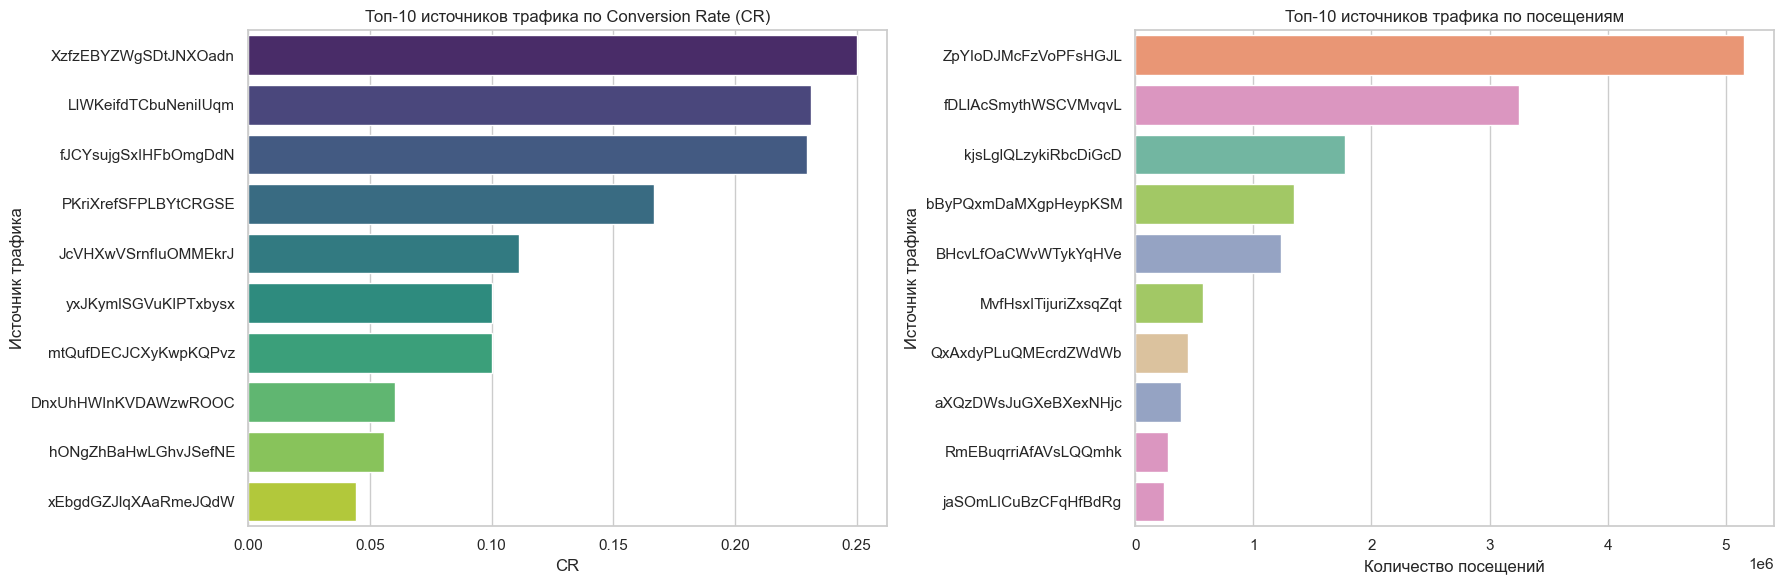

In [87]:
sns.set_theme(style="whitegrid")

# Визуализация Топ-10 источников трафика по CR и Топ-10 источников трафика по объему

fig, axes = plt.subplots(1, 2, figsize=(18, 6)) 

sns.barplot(x=traffic_by_source["CR"].head(10), y=traffic_by_source.head(10).index, hue=traffic_by_source.head(10).index, palette="viridis", legend=False,
    ax=axes[0])
axes[0].set_title("Топ-10 источников трафика по Conversion Rate (CR)")
axes[0].set_xlabel("CR")
axes[0].set_ylabel("Источник трафика")

sns.countplot(y=df['utm_source'], hue=df['utm_source'], order=df['utm_source'].value_counts().index[:10], palette="Set2", dodge=False, ax=axes[1])
axes[1].set_title("Топ-10 источников трафика по посещениям")
axes[1].set_xlabel("Количество посещений")
axes[1].set_ylabel("Источник трафика")
axes[1].legend([], [], frameon=False) 

# Отображаем оба графика
plt.tight_layout() 
plt.show()

In [88]:
# Вывод: как мы видим,самый результативный источник по CR даже не входит в 10-ку источников по объему. И наоборот,
# самый посещаемый источник не входит в 10-ку с самым целевым трафиком. Делаем упор на источники по CR!!!!

In [89]:
# Анализ трафика по устройствам (device_category)
traffic_by_device = df.groupby("device_category").agg(total_visits=("session_id", "count"), total_conversions=("is_converted", "sum"))

In [90]:
traffic_by_device["CR"] = traffic_by_device["total_conversions"] / traffic_by_device["total_visits"]

In [91]:
traffic_by_device = traffic_by_device.sort_values(by="CR", ascending=False)

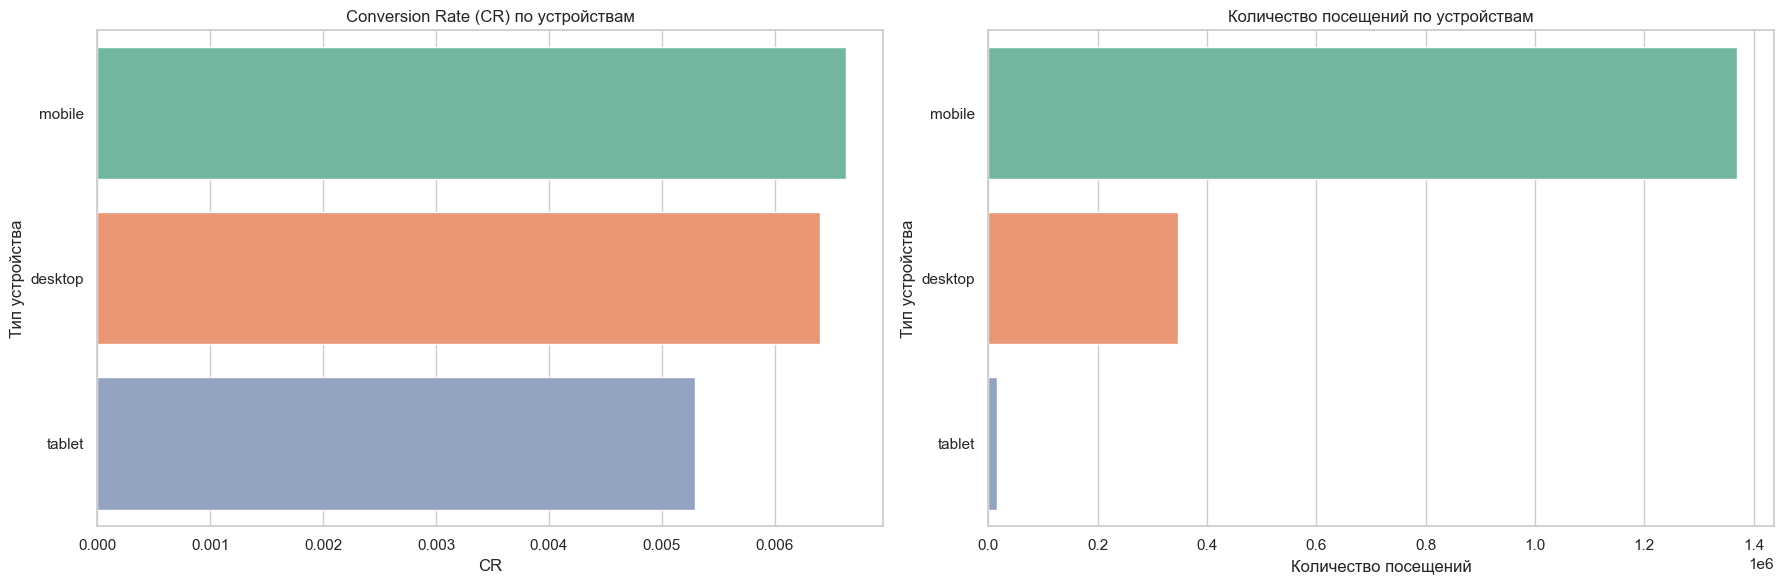

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x=traffic_by_device["CR"], y=traffic_by_device.index, hue=traffic_by_device.index, palette="Set2", ax=axes[0], legend=False)
axes[0].set_title("Conversion Rate (CR) по устройствам")
axes[0].set_xlabel("CR")
axes[0].set_ylabel("Тип устройства")

sns.countplot(y=df_sessions['device_category'], hue=df_sessions['device_category'], order=df_sessions['device_category'].value_counts().index, palette="Set2", dodge=False, ax=axes[1], legend=False)
axes[1].set_title("Количество посещений по устройствам")
axes[1].set_xlabel("Количество посещений")
axes[1].set_ylabel("Тип устройства")
axes[1].legend([], [], frameon=False)

plt.tight_layout()
plt.show()

In [93]:
# Вывод: разница между объемом посещений по устройствам велика, а разница между CR по устройствам маленькая, но все-равно видно, что упор идет на mobile устройства

In [94]:
# Анализ трафика по кампаниям (utm_campaign)
traffic_by_campaign = df.groupby("utm_campaign").agg(total_visits=("session_id", "count"), total_conversions=("is_converted", "sum"))

In [95]:
traffic_by_campaign["CR"] = traffic_by_campaign["total_conversions"] / traffic_by_campaign["total_visits"]

In [96]:
traffic_by_campaign = traffic_by_campaign.sort_values(by="CR", ascending=False)

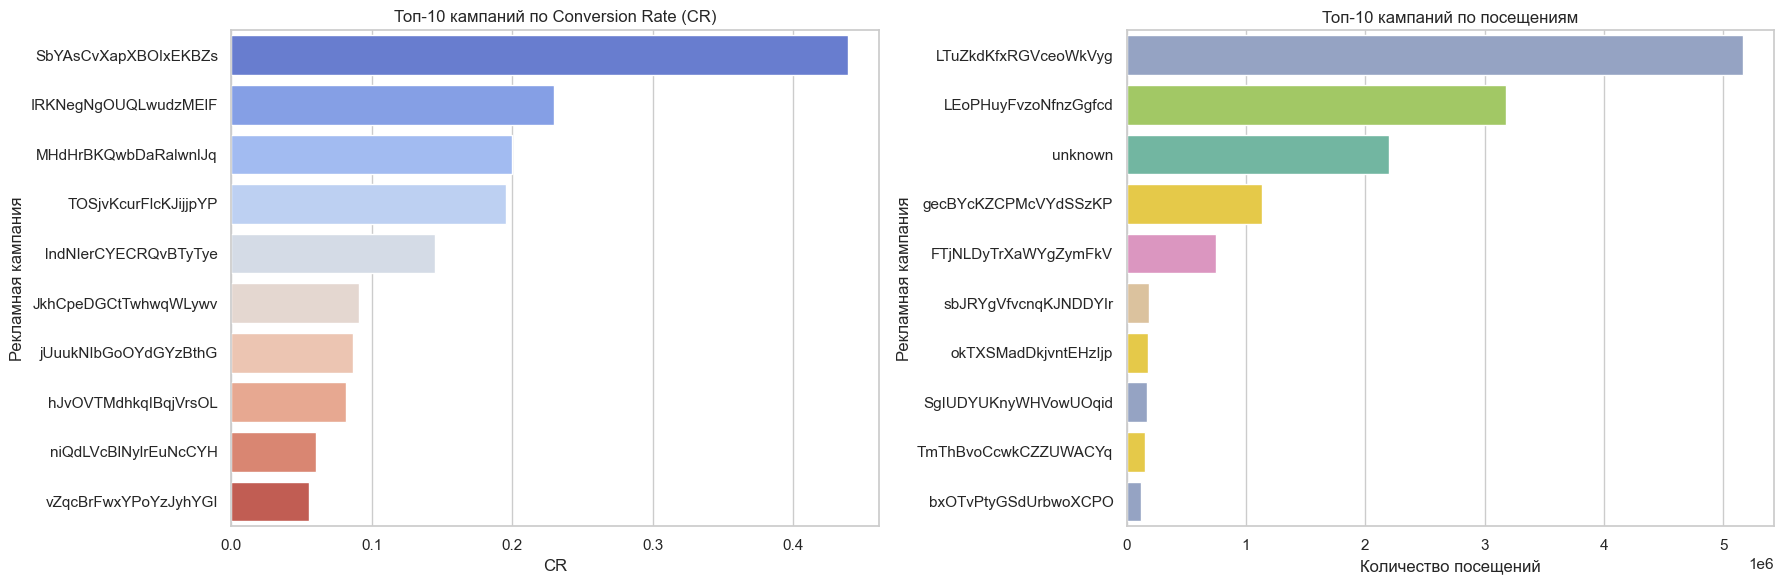

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x=traffic_by_campaign["CR"].head(10), y=traffic_by_campaign.head(10).index, hue=traffic_by_campaign.head(10).index, palette="coolwarm", ax=axes[0], legend=False)
axes[0].set_title("Топ-10 кампаний по Conversion Rate (CR)")
axes[0].set_xlabel("CR")
axes[0].set_ylabel("Рекламная кампания")

sns.countplot(y=df['utm_campaign'], hue=df['utm_campaign'], order=df['utm_campaign'].value_counts().index[:10], palette="Set2", dodge=False, ax=axes[1], legend=False)
axes[1].set_title("Топ-10 кампаний по посещениям")
axes[1].set_xlabel("Количество посещений")
axes[1].set_ylabel("Рекламная кампания")
axes[1].legend([], [], frameon=False)

plt.tight_layout()
plt.show()

In [98]:
# Вывод: ситуация повторяется: такая же как и с источниками трафика. Лидирующие компании по CR не совпадают с компаниями по объему трафика.

In [99]:
# Анализ трафика по регионам (geo_city)

traffic_by_city = df.groupby("geo_city").agg(total_visits=("session_id", "count"), total_conversions=("is_converted", "sum"))

In [100]:
traffic_by_city["CR"] = traffic_by_city["total_conversions"] / traffic_by_city["total_visits"]

In [101]:
traffic_by_city = traffic_by_city.sort_values(by="CR", ascending=False)

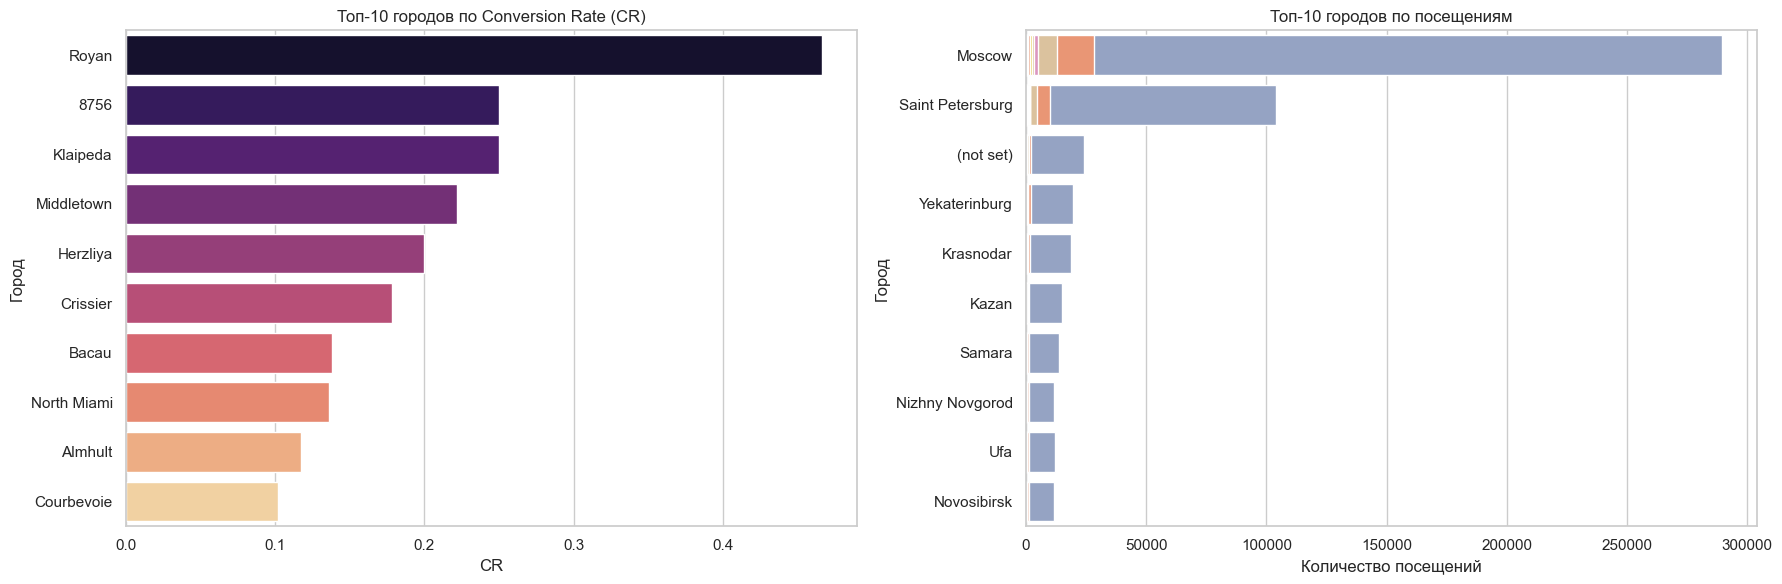

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x=traffic_by_city["CR"].head(10), y=traffic_by_city.head(10).index, hue=traffic_by_city.head(10).index, palette="magma", ax=axes[0])
axes[0].set_title("Топ-10 городов по Conversion Rate (CR)")
axes[0].set_xlabel("CR")
axes[0].set_ylabel("Город")

sns.countplot(y=df['geo_city'], hue=df_sessions['geo_city'], order=df['geo_city'].value_counts().index[:10], palette="Set2", dodge=False, ax=axes[1])
axes[1].set_title("Топ-10 городов по посещениям")
axes[1].set_xlabel("Количество посещений")
axes[1].set_ylabel("Город")
axes[1].legend([], [], frameon=False)

plt.tight_layout()
plt.show()

In [103]:
# Вывод: аналогичен предыдущим графикам: не совпадают города по объему посещений и по CR.

## Вопрос 2

In [105]:
# Какие авто пользуются большим спросом? У каких авто лучший показатель CR?

In [106]:
# извлекаем марку автомобиля из предоставленного url 
df['brand'] = df['hit_page_path'].str.split('/').str[3].where(df['hit_page_path'].str.contains('/cars/all/'), 'unknown')

In [108]:
# извлекаем модель
df['model'] = df['hit_page_path'].str.split('/').str[4].where(df['hit_page_path'].str.contains('/cars/all/'), 'unknown')

In [110]:
df[['brand', 'model']].head(10)

,brand,model
0,unknown,unknown
1,unknown,unknown
2,volkswagen,polo
3,unknown,unknown
4,mercedes-benz,cla-klasse
5,unknown,unknown
6,unknown,unknown
7,mercedes-benz,glc
8,kia,sorento
9,nissan,x-trail


In [114]:
top_cars_by_requests = df.groupby("brand").size().sort_values(ascending=False).head(10)

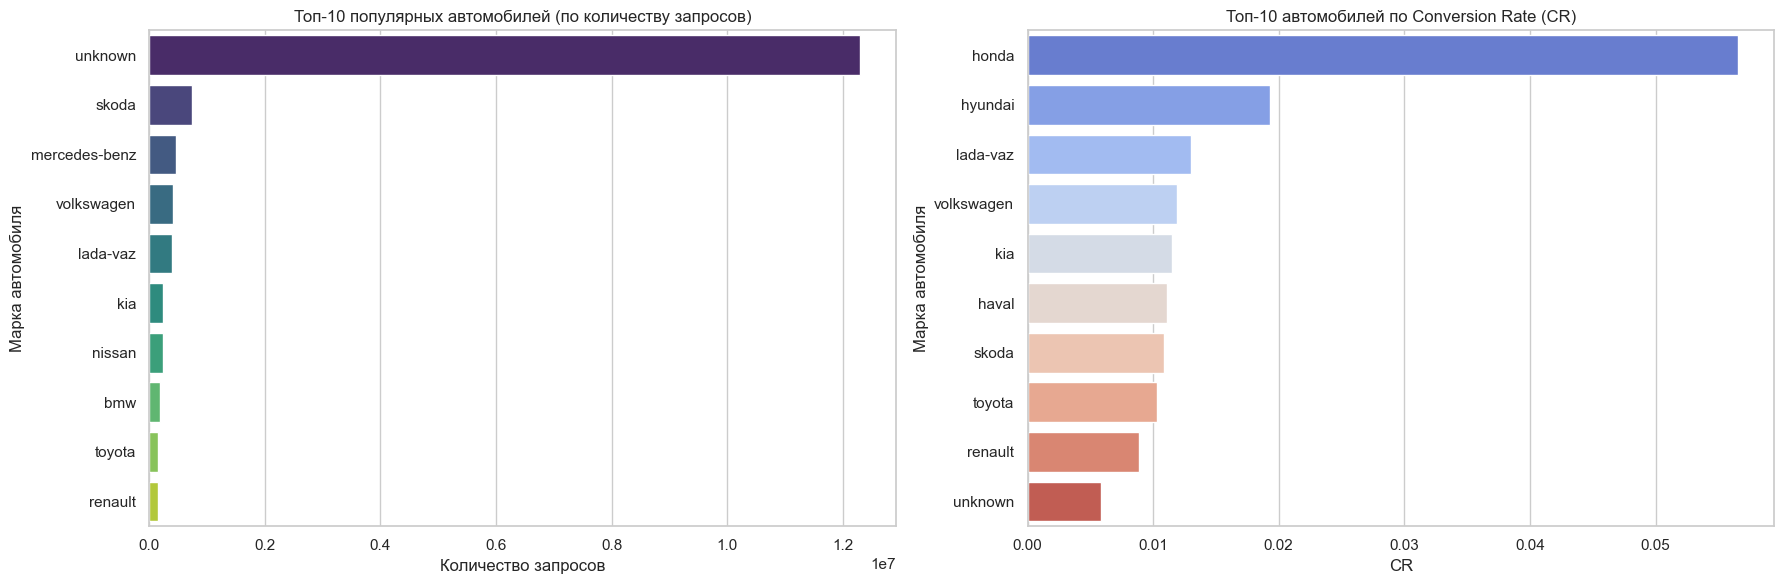

In [118]:
# Создаем графики для автомобилей (размещены рядом)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# 1. Популярные автомобили (по количеству запросов)
sns.barplot(x=top_cars_by_requests.values, y=top_cars_by_requests.index, hue=top_cars_by_requests.index, palette="viridis", ax=axes[0], legend=False)
axes[0].set_title("Топ-10 популярных автомобилей (по количеству запросов)")
axes[0].set_xlabel("Количество запросов")
axes[0].set_ylabel("Марка автомобиля")

# 2. График автомобилей с наилучшим CR
car_cr = df.groupby("brand")["is_converted"].mean().sort_values(ascending=False).head(10)
sns.barplot(x=car_cr.values, y=car_cr.index, hue=car_cr.index, palette="coolwarm", ax=axes[1], legend=False)
axes[1].set_title("Топ-10 автомобилей по Conversion Rate (CR)")
axes[1].set_xlabel("CR")
axes[1].set_ylabel("Марка автомобиля")

plt.tight_layout()
plt.show()

In [120]:
# Вывод: если смотреть на график "по количеству запросов", то видим что лидер по количеству - пустая строка, т.е. это говорит о том , 
# что пользователи просто просмвтривали страницу без конкретного целевого действия. На втором месте просто по просмотрам = Skoda.

# Лидер по CR = Honda, за мней идет hyundai, но и skoda присутствиет в этом списке. Поэтому как вариант можно развивать автопарк марки skoda)))

## Вопрос 3

In [ ]:
# Стоит ли увеличивать свое присутствие в соцсетях и давать там больше рекламы?

In [124]:
social_media_sources = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 
                        'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 
                        'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']

In [126]:
social_media_traffic = df[df["utm_source"].isin(social_media_sources)] # трафик соцсетей

In [130]:
social_traffic_share = len(social_media_traffic) / len(df)*100  # Доля соцсетей в общем трафике
print (social_traffic_share)

7.666619127217797


In [134]:
# Сравнение CR из соцсетей и из других источников
social_cr = social_media_traffic["is_converted"].mean()  # Средний CR для соцсетей
other_cr = df[~df["utm_source"].isin(social_media_sources)]["is_converted"].mean()  # Средний CR для других источников

In [138]:
# Формула для рекомендации по увеличению рекламы в соцсетях:

recommendation = f"""
CR из соцсетей: {social_cr:.2%}
CR из других источников: {other_cr:.2%}

Рекомендация: {"Увеличить рекламу в соцсетях" if social_cr > other_cr else "Не увеличивать рекламные вложения в соцсети"}
"""
print(recommendation)


CR из соцсетей: 0.67%
CR из других источников: 0.65%

Рекомендация: Увеличить рекламу в соцсетях



In [ ]:
# Вывод: стоит увеличивать присутствие в соцсетях и увеличить бюджет на рекламу в соцсетях

# ВЫВОД И РЕКОМЕНДАЦИИ

### Программа "СберАвтоподписка" показывает высокую востребованность, но есть возможности для роста продаж:

* Оптимизация рекламных кампаний в соцсетях:
     - Увеличить рекламу в соцсетях – несмотря на меньший объем трафика из соцсетей, их CR выше, чем у других источников, что делает рекламу                   эффективной.
     - Фокус на десктопную аудиторию – стоит адаптировать рекламные кампании и лендинги под повышение конверсии мобильных пользователей.
     - Оптимизировать платный трафик – раз органический трафик конвертируется в 2 раза лучше, следует снизить затраты на платную рекламу или изменить          стратегию привлечения платных пользователей.
* Увеличение присутствия Skoda в автопарке.
* Фокус на повышение мобильной конверсии.
* Оптимизация работы с регионами с высоким CR, но низким трафиком.

Мне кажется, что реализация этих рекомендаций поможет увеличить продажи и эффективность "СберАвтоподписки".

Что можно предложить для увеличения пользователей "СберАвтоподписки"?
Где искать клиентов?
 1. Улучшить SEO-оптимизацию сайта по запросам ("долгосрочная аренда авто", "машина в подписку", "аренда авто на 1 год", "что лучше: кредит или              подписка") и запустить контекстную рекламу на тематику "аренда авто vs покупка" в Яндекс.Директ и Google Ads на эти запросы.
 2. Таргетированная реклама в соцсетях (Instagram, Telegram, YouTube, TikTok).
 3. Автофорумы и сайты (Drom.ru, Авито, Auto.ru, Drive2): реклама, создать экспертные статьи с анализом цен, выгод подписки и отзывами клиентов.
 4. B2B-сегмент (компании, каршеринг, такси, бизнес-центры, лизинг).
    
 Как увеличить продажи?
 1. Оптимизировать мобильную версию сайта.
 2. Добавить онлайн-калькулятор "Подписка vs Кредит".
 3. Запустить ретаргетинг и спецпредложения ("Первый месяц бесплатно").
 4. Добавить в автопарк больше моделей Skoda, Hyundai, Honda.
 5. Сконцентрироваться на регионах с высоким CR.